In [2]:
from ast import literal_eval
from csv import reader
from os import listdir, makedirs, path
from pickle import dump
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from model import Seq2Seq, RecurrentAutoencoder, DNNAE, SalTransformer, SalAE, SalSCINet, SalGATSCINet, SalGATSCINetV2, SalGATConvLSTM, SalGATConvGRU, ConvGRU, SalGATConvGRUwoSal, SalConvGRUwoALL, SalGATConvGRUwoGAT


import os, random
import torch
from torch.nn import TransformerAE
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
# from args import get_parser


def load_and_save(category, filename, dataset, dataset_folder, output_folder):
    temp = np.genfromtxt(
        path.join(dataset_folder, category, filename),
        dtype=np.float32,
        delimiter=",",
    )
    print(dataset, category, filename, temp.shape)
    with open(path.join(output_folder, dataset + "_" + category + ".pkl"), "wb") as file:
        dump(temp, file)


def load_data(dataset):
    """ Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly) """

    if dataset == "SMD":
        dataset_folder = "/home/sangyup/saliency_anomaly_detection/dataset/ServerMachineDataset"
        output_folder = "/home/sangyup/saliency_anomaly_detection/dataset/ServerMachineDataset/processed"
        makedirs(output_folder, exist_ok=True)
        file_list = listdir(path.join(dataset_folder, "train"))
        for filename in file_list:
            if filename.endswith(".txt"):
                load_and_save(
                    "train",
                    filename,
                    filename.strip(".txt"),
                    dataset_folder,
                    output_folder,
                )
                load_and_save(
                    "test_label",
                    filename,
                    filename.strip(".txt"),
                    dataset_folder,
                    output_folder,
                )
                load_and_save(
                    "test",
                    filename,
                    filename.strip(".txt"),
                    dataset_folder,
                    output_folder,
                )

    elif dataset == "SMAP" or dataset == "MSL":
        dataset_folder = "/home/sangyup/saliency_anomaly_detection/dataset/SMAPMSL/data"
        output_folder = "/home/sangyup/saliency_anomaly_detection/dataset/SMAPMSL/data/processed"
        makedirs(output_folder, exist_ok=True)
        with open(path.join(dataset_folder, "labeled_anomalies.csv"), "r") as file:
            csv_reader = reader(file, delimiter=",")
            res = [row for row in csv_reader][1:]
        res = sorted(res, key=lambda k: k[0])
        data_info = [row for row in res if row[1] == dataset and row[0] != "P-2"]
        labels = []
        for row in data_info:
            anomalies = literal_eval(row[2])
            length = int(row[-1])
            label = np.zeros([length], dtype=np.bool_)
            for anomaly in anomalies:
                label[anomaly[0] : anomaly[1] + 1] = True
            labels.extend(label)

        labels = np.asarray(labels)
        print(dataset, "test_label", labels.shape)

        with open(path.join(output_folder, dataset + "_" + "test_label" + ".pkl"), "wb") as file:
            dump(labels, file)

        def concatenate_and_save(category):
            data = []
            for row in data_info:
                filename = row[0]
                temp = np.load(path.join(dataset_folder, category, filename + ".npy"))
                data.extend(temp)
            data = np.asarray(data)
            print(dataset, category, data.shape)
            with open(path.join(output_folder, dataset + "_" + category + ".pkl"), "wb") as file:
                dump(data, file)

        for c in ["train", "test"]:
            concatenate_and_save(c)

def normalize_data(data, scaler=None):
    data = np.asarray(data, dtype=np.float32)
    if np.any(sum(np.isnan(data))):
        data = np.nan_to_num(data)

    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(data)
    data = scaler.transform(data)
    print("Data normalized")

    return data, scaler

def get_data_dim(dataset):
    """
    :param dataset: Name of dataset
    :return: Number of dimensions in data
    """
    if dataset == "SMAP":
        return 25
    elif dataset == "MSL":
        return 55
    elif str(dataset).startswith("machine"):
        return 38
    else:
        raise ValueError("unknown dataset " + str(dataset))

        
def get_data(dataset, max_train_size=None, max_test_size=None,
             normalize=False, spec_res=False, train_start=0, test_start=0):
    """
    Get data from pkl files

    return shape: (([train_size, x_dim], [train_size] or None), ([test_size, x_dim], [test_size]))
    Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly)
    """
    prefix = "/home/sangyup/saliency_anomaly_detection/dataset"
    if str(dataset).startswith("machine"):
        prefix += "/ServerMachineDataset/processed"
    elif dataset in ["MSL", "SMAP"]:
        prefix += "/SMAPMSL/data/processed"
    if max_train_size is None:
        train_end = None
    else:
        train_end = train_start + max_train_size
    if max_test_size is None:
        test_end = None
    else:
        test_end = test_start + max_test_size
    print("load data of:", dataset)
    print("train: ", train_start, train_end)
    print("test: ", test_start, test_end)
    x_dim = get_data_dim(dataset)
    f = open(os.path.join(prefix, dataset + "_train.pkl"), "rb")
    train_data = pickle.load(f).reshape((-1, x_dim))[train_start:train_end, :]
    f.close()
    try:
        f = open(os.path.join(prefix, dataset + "_test.pkl"), "rb")
        test_data = pickle.load(f).reshape((-1, x_dim))[test_start:test_end, :]
        f.close()
    except (KeyError, FileNotFoundError):
        test_data = None
    try:
        f = open(os.path.join(prefix, dataset + "_test_label.pkl"), "rb")
        test_label = pickle.load(f).reshape((-1))[test_start:test_end]
        f.close()
    except (KeyError, FileNotFoundError):
        test_label = None

    if normalize:
        train_data, scaler = normalize_data(train_data, scaler=None)
        test_data, _ = normalize_data(test_data, scaler=scaler)

    print("train set shape: ", train_data.shape)
    print("test set shape: ", test_data.shape)
    print("test set label shape: ", None if test_label is None else test_label.shape)
    return (train_data, None), (test_data, test_label)

In [3]:
ds = 'MSL'
load_data(ds.upper())

MSL test_label (73729,)
MSL train (58317, 55)
MSL test (73729, 55)


In [4]:
# (x_train, _), (x_test, y_test) = get_data('machine-1-3', normalize=True)
(x_train, _), (x_test, y_test) = get_data('MSL', normalize=True)

load data of: MSL
train:  0 None
test:  0 None
Data normalized
Data normalized
train set shape:  (58317, 55)
test set shape:  (73729, 55)
test set label shape:  (73729,)


In [5]:
def split_series(series, n_past, n_future):
    '''

    :param series: input time series
    :param n_past: number of past observations
    :param n_future: number of future series
    :return: X, y(label)
    '''
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)

    return X, y

x_test_windowed, _ = split_series(x_test, 100, 1)
np.array(x_test_windowed).shape

(73629, 100, 55)

In [6]:
from torch.utils.data import Dataset, DataLoader
class ReconDataset(Dataset):
    def __init__(self, data, window, target_cols):
        self.data = torch.Tensor(data)
        self.window = window
        self.target_cols = target_cols
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        y = self.data[index:index+self.window]
        return x, y

    def __len__(self):
        return len(self.data) -  self.window 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)

    def __getsize__(self):
        return (self.__len__())

class ForecastDataset(Dataset):
    def __init__(self, data, window, target_cols):
        self.data = torch.Tensor(data)
        self.window = window
        self.target_cols = target_cols
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        y = self.data[index+self.window,0:self.target_cols]
        return x, y

    def __len__(self):
        return len(self.data) -  self.window 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

class ReconForecastDataset(Dataset):
    def __init__(self, data, window, horizon):
        self.data = torch.Tensor(data)
        self.window = window
        self.horizon = horizon
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        y_recon = self.data[index:index+self.window]
        y_fore = self.data[index+self.window:index+self.window+self.horizon]
        return x, y_recon, y_fore

    def __len__(self):
        return len(self.data) -  self.window 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape), (self.__len__(), *self.__getitem__(0)[1].shape), (self.__len__(), *self.__getitem__(0)[2].shape)
    
    def __getsize__(self):
        return (self.__len__())


def create_data_loaders(train_dataset, batch_size, val_split=0.1, shuffle=False, test_dataset=None):
    train_loader, val_loader, test_loader = None, None, None
    if val_split == 0.0:
        print(f"train_size: {len(train_dataset)}")
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)

    else:
        dataset_size = len(train_dataset)
        indices = list(range(dataset_size))
        split = int(np.floor(val_split * dataset_size))
        if shuffle:
            np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=train_sampler, drop_last=True)
        val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=valid_sampler, drop_last=True)

        print(f"train_size: {len(train_indices)}")
        print(f"validation_size: {len(val_indices)}")

    if test_dataset is not None:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
        print(f"test_size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader


# From Informer

class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean

# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y


class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='h'
        else:
            self.freq='t'

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

In [6]:
window_size = 100
batch_size = 512

train_dataset = ReconDataset(x_train, window_size, 1)
test_dataset = ReconDataset(x_test, window_size, 1)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, batch_size, val_split=0.0, shuffle=True, test_dataset=test_dataset)

train_size: 58217
test_size: 73629


In [ ]:
indices = torch.arange(len(train_dataset)-horizon)
temp = torch.utils.data.Subset(train_dataset, indices)
print(len(train_dataset))
print(len(temp))

NameError: name 'horizon' is not defined

In [6]:
window_size = 100
batch_size = 512
horizon = 10




train_dataset = ReconForecastDataset(x_train, window_size, horizon)
indices = torch.arange(len(train_dataset)-horizon)
train_dataset = torch.utils.data.Subset(train_dataset, indices)
test_dataset = ReconForecastDataset(x_test, window_size, horizon)

# val_split = 0.3
# split = int(np.floor(val_split * len(train_dataset)))
# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset) - split, split])


# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

train_loader, val_loader, test_loader = create_data_loaders(train_dataset, batch_size, val_split=0.3, shuffle=False, test_dataset=test_dataset)

train_size: 40745
validation_size: 17462
test_size: 73629


In [7]:
from time import time

def train(dataloader, model, batch_size, n_epochs):
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for i, (x,y) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.cuda()
            # guess = model(given,given)  # Transformer
            enc_output, guess = model(x)  # AE
            y = y.cuda()
            loss = loss_fn(y, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}]')
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history


def train_DNN(dataloader, model, batch_size, n_epochs):
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for i, (x,y) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]).cuda()
            # guess = model(given,given)  # Transformer
            enc_output, guess = model(x)  # AE
            y = y.reshape(y.shape[0], y.shape[1]*y.shape[2]).cuda()
            loss = loss_fn(y, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}]')
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history


def train_transformer(dataloader, model, batch_size, n_epochs):
    optimizer = torch.optim.AdamW(model.parameters())
    
    loss_fn_AE = torch.nn.MSELoss()
    loss_fn_transformer = torch.nn.MSELoss()

    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history, loss_history_AE, loss_history_TF = [], [], []
    for e in epochs:
        start = time()
        epoch_loss = 0
        epoch_loss_AE = 0
        epoch_loss_transformer = 0
        for i, (x,y) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.cuda()
            sal, dec_x, out = model(x)
            y = y.cuda()
            loss_AE = loss_fn_AE(y, dec_x)
            loss_transformer = loss_fn_transformer(y, out)
            loss = loss_AE + loss_transformer
            loss.backward()
            epoch_loss += loss.item()
            epoch_loss_AE += loss_AE.item()
            epoch_loss_transformer += loss_transformer.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        loss_history_AE.append(epoch_loss_AE)
        loss_history_TF.append(epoch_loss_transformer)

#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}], AE loss: [{epoch_loss_AE}], TF loss: [{epoch_loss_transformer}] took', time()-start)
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["loss_AE"] = epoch_loss_AE
            best["loss_TF"] = epoch_loss_transformer
            best["epoch"] = e + 1
    return best, loss_history, loss_history_AE, loss_history_TF


def train_SCI(dataloader, model, batch_size, n_epochs):
    optimizer = torch.optim.AdamW(model.parameters())
    
    loss_fn_AE = torch.nn.MSELoss()
    loss_fn_sci = torch.nn.MSELoss()

    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history, loss_history_AE, loss_history_TF = [], [], []
    for e in epochs:
        start = time()
        epoch_loss = 0
        epoch_loss_AE = 0
        epoch_loss_sci = 0
        for i, (x,y_recon,y_fore) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.cuda()
            y_recon = y_recon.cuda()
            y_fore = y_fore.cuda()
            sal, dec_x, out = model(x)
            
            loss_AE = loss_fn_AE(y_recon, dec_x)
            loss_sci = loss_fn_sci(y_fore, out)
            loss = loss_AE + loss_sci
            loss.backward()
            epoch_loss += loss.item()
            epoch_loss_AE += loss_AE.item()
            epoch_loss_sci += loss_sci.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        loss_history_AE.append(epoch_loss_AE)
        loss_history_TF.append(epoch_loss_sci)

#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}], AE loss: [{epoch_loss_AE}], TF loss: [{epoch_loss_sci}] took', time()-start)
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["loss_AE"] = epoch_loss_AE
            best["loss_TF"] = epoch_loss_sci
            best["epoch"] = e + 1
    return best, loss_history, loss_history_AE, loss_history_TF
 

def train_model(dataloader, val_loader, model, batch_size, n_epochs, model_name):
    optimizer = torch.optim.AdamW(model.parameters())
    
    loss_fn_AE = torch.nn.MSELoss()
    loss_fn_sci = torch.nn.MSELoss()

    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history, loss_history_AE, loss_history_TF = [], [], []
    val_loss_history, val_loss_history_AE, val_loss_history_TF = [], [], []
    for e in epochs:
        model.train()
        start = time()
        epoch_loss = 0
        epoch_loss_AE = 0
        epoch_loss_sci = 0
        for i, (x,y_recon,y_fore) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.cuda()
            y_recon = y_recon.cuda()
            y_fore = y_fore.cuda()
            sal, dec_x, out = model(x)
            
            loss_AE = loss_fn_AE(y_recon, dec_x)
            loss_sci = loss_fn_sci(y_fore, out)
            loss = loss_AE + loss_sci
            loss.backward()
            epoch_loss += loss.item()
            epoch_loss_AE += loss_AE.item()
            epoch_loss_sci += loss_sci.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        loss_history_AE.append(epoch_loss_AE)
        loss_history_TF.append(epoch_loss_sci)

#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        # Validation step
        model.eval()
        val_epoch_loss = 0
        val_epoch_loss_AE = 0
        val_epoch_loss_sci = 0
        with torch.no_grad():
            for i, (x,y_recon,y_fore) in enumerate(val_loader):  
                x = x.cuda()
                y_recon = y_recon.cuda()
                y_fore = y_fore.cuda()
                sal, dec_x, out = model(x)

                valloss_AE = loss_fn_AE(y_recon, dec_x)
                valloss_sci = loss_fn_sci(y_fore, out)
                valloss = valloss_AE + valloss_sci
                
                val_epoch_loss += valloss.item()
                val_epoch_loss_AE += valloss_AE.item()
                val_epoch_loss_sci += valloss_sci.item()
                
                val_loss_history.append(val_epoch_loss)
                val_loss_history_AE.append(val_epoch_loss_AE)
                val_loss_history_TF.append(val_epoch_loss_sci)  

        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}], AE loss: [{epoch_loss_AE}], TF loss: [{epoch_loss_sci}] took', time()-start)
        print(f'Validation loss EPOCH: [{e+1}|{len(epochs)}], validation loss: [{val_epoch_loss}], AE loss: [{val_epoch_loss_AE}], TF loss: [{val_epoch_loss_sci}]')
        if val_epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = val_epoch_loss
            best["loss_AE"] = val_epoch_loss_AE
            best["loss_TF"] = val_epoch_loss_sci
            best["epoch"] = e + 1
            with open("result/model_" + model_name + "_best.pt", "wb") as f:
                torch.save(
                    {
                        "state": best["state"],
                        "best_epoch": best["epoch"],
                        "loss_history": val_loss_history,
                        "loss_AE_history": val_loss_history_AE,
                        "loss_TF_history": val_loss_history_TF,
                    },
                    f,
                )

    # Save last epoch
    with open("result/model_" + model_name + "_last.pt", "wb") as f:
        torch.save(
            {
                "state": model.state_dict(),
                "best_epoch": e + 1,
                "loss_history": val_loss_history,
                "loss_AE_history": val_loss_history_AE,
                "loss_TF_history": val_loss_history_TF,
            },
            f,
        )

    return best, loss_history, loss_history_AE, loss_history_TF
 

In [8]:
# MODEL = RecurrentAutoencoder(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2))
# MODEL = SalTransformer(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, n_head=5, cell='lstm')
# MODEL = SalAE(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalSCINet(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')

# MODEL = SalGATSCINet(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATSCINetV2(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATConvLSTM(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATConvGRU(seq_len=window_size, output_len=10, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATConvGRUwoSal(seq_len=window_size, output_len=10, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
MODEL = SalConvGRUwoALL(seq_len=window_size, output_len=10, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
MODEL.cuda()
MODEL.train()

SalConvGRUwoALL(
  (encoder): RecurEncoder(
    (rnn1): GRU(55, 54, batch_first=True)
    (rnn2): GRU(54, 27, batch_first=True)
  )
  (decoder): RecurDecoder(
    (rnn1): GRU(27, 27, batch_first=True)
    (rnn2): GRU(27, 54, batch_first=True)
    (output_layer): Linear(in_features=54, out_features=55, bias=True)
    (timedist): TimeDistributed(
      (module): Linear(in_features=54, out_features=55, bias=True)
    )
  )
  (feature_gat): FeatureAttentionLayer(
    (lin): Linear(in_features=100, out_features=100, bias=True)
    (leakyrelu): LeakyReLU(negative_slope=0.2)
    (sigmoid): Sigmoid()
  )
  (temporal_gat): TemporalAttentionLayer(
    (lin): Linear(in_features=55, out_features=55, bias=True)
    (leakyrelu): LeakyReLU(negative_slope=0.2)
    (sigmoid): Sigmoid()
  )
  (convGRU): ConvGRU(
    (cell_list): ModuleList(
      (0): ConvGRUCell(
        (conv_gates): Conv2d(87, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_can): Conv2d(87, 32, kernel_size=(3, 3)

In [9]:
model_name = 'SalGATConvGRUwoAll_saliency_MSL'
BEST_MODEL, LOSS_HISTORY, LOSS_HISTORY_AE, LOSS_HISTORY_TF = train_model(train_loader, val_loader, MODEL, batch_size, 1000, model_name)
# with open("result/model_SalGATConvGRU_saliency_MSL.pt", "wb") as f:
#     torch.save(
#         {
#             "state": BEST_MODEL["state"],
#             "best_epoch": BEST_MODEL["epoch"],
#             "loss_history": LOSS_HISTORY,
#             "loss_AE_history": LOSS_HISTORY_AE,
#             "loss_TF_history": LOSS_HISTORY_TF,
#         },
#         f,
#     )

Training loss EPOCH: [1|1000], training loss: [0.8351437486708164], AE loss: [0.4062061086297035], TF loss: [0.42893764143809676] took 9.77617073059082
Validation loss EPOCH: [1|1000], validation loss: [0.33475812152028084], AE loss: [0.16696897009387612], TF loss: [0.167789151892066]
Training loss EPOCH: [2|1000], training loss: [0.6546003115363419], AE loss: [0.3240144355222583], TF loss: [0.33058587717823684] took 9.586318969726562
Validation loss EPOCH: [2|1000], validation loss: [0.3115943782031536], AE loss: [0.1542913462035358], TF loss: [0.15730303199961782]
Training loss EPOCH: [3|1000], training loss: [0.635971758980304], AE loss: [0.31510387430898845], TF loss: [0.3208678839728236] took 9.682246685028076
Validation loss EPOCH: [3|1000], validation loss: [0.2977301552891731], AE loss: [0.1492515429854393], TF loss: [0.14847861416637897]
Training loss EPOCH: [4|1000], training loss: [0.6292705605737865], AE loss: [0.3122178551275283], TF loss: [0.3170527059119195] took 8.98662

In [17]:
input_tensor = torch.rand(512, 10, 220, 10, 1)  # (b,t,c,h,w)

model = ConvGRU(input_size=(10, 1),
                input_dim=220,
                hidden_dim=[55,55,55],
                kernel_size=(3,3),
                num_layers=3,
                dtype=torch.FloatTensor,
                batch_first=True,
                bias = True,
                return_all_layers = False)
a,b = model(input_tensor)
print(len(a))

3


In [9]:
model_name = 'SalGATConvGRUwo_saliency_MSL'
with open("result/model_" + model_name + "_best.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

print(SAVED_MODEL['best_epoch'])

# MODEL = SalGATSCINet(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATSCINetV2(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATConvLSTM(seq_len=window_size, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATConvGRU(seq_len=window_size, output_len=10, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
# MODEL = SalGATConvGRUwoSal(seq_len=window_size, output_len=10, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')
MODEL = SalConvGRUwoALL(seq_len=window_size, output_len=10, n_features=x_train.shape[1], out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2), kernel_size=3, cell='gru')

MODEL.cuda()    
MODEL.load_state_dict(SAVED_MODEL["state"])


# trained_encoder = list(MODEL.children())[0]
# trained_decoder = list(MODEL.children())[1]
 
# # Test the decoder
# x = trained_decoder(torch.Tensor(np.random.rand(512,1,12)).cuda())
# x.shape


13


<All keys matched successfully>

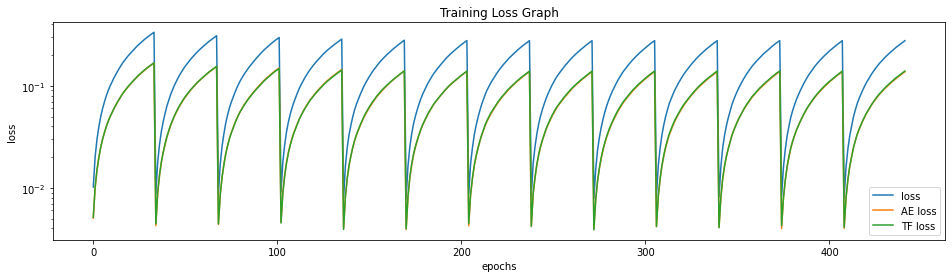

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"], label='loss')
plt.plot(SAVED_MODEL["loss_AE_history"], label='AE loss')
plt.plot(SAVED_MODEL["loss_TF_history"], label='TF loss')
plt.legend()
plt.show()

In [11]:
def inference(dataloader, model, batch_size, TF_alpha):
    dist, dist_sal, fin_dist, guess, sal_list = [], [], [], [], []
    mse = torch.nn.MSELoss()
    model.eval()
    with torch.no_grad():
        for i, (x,y) in enumerate(dataloader):
            x = x.cuda()
            y = y.cuda()
            
            sal, dec_x, out = model(x)
            
            for y_s, d, o in zip(y, dec_x, out):
                dist_sal.append(torch.sum(torch.abs(y_s - d)).cpu().numpy())
                # dist_sal.append(mse(y_s,d).item())
                # dist_sal.append(torch.cdist(y_s, d, p=2.0).cpu().numpy())  
                
                dist.append(torch.sum(torch.abs(y_s - o)).cpu().numpy())
                # dist.append(mse(y_s, o).item())
                # dist.append(torch.cdist(y_s, o, p=2.0).cpu().numpy())  

                fin_dist.append((1-TF_alpha)*torch.sum(torch.abs(y_s - d)).cpu().numpy() + TF_alpha*torch.sum(torch.abs(y_s - o)).cpu().numpy())
                # fin_dist.append((1-TF_alpha)*mse(y_s,d).item() + TF_alpha*mse(y_s, o).item())
                # fin_dist.append((TF_alpha*torch.cdist(y_s, o, p=2.0) + (1-TF_alpha)*torch.cdist(y_s, d, p=2.0)).cpu().numpy())

            guess.append(out.cpu().numpy())
            sal_list.append(sal.cpu().numpy())
        
            
    return (
        dist,
        dist_sal,
        fin_dist,
        np.concatenate(guess),
        np.concatenate(sal_list)
    )


def inference_SAL(dataloader, model, batch_size, TF_alpha):
    dist, dist_sal, fin_dist1, fin_dist2, guess, sal_list = [], [], [], [], [], []
    mse = torch.nn.MSELoss()
    model.eval()
    with torch.no_grad():
        for i, (x,y_recon,y_fore) in enumerate(dataloader):
            x = x.cuda()
            y_recon = y_recon.cuda()
            y_fore = y_fore.cuda()
            
            sal, dec_x, out = model(x)
            
            for y_r, y_f, d, o in zip(y_recon, y_fore, dec_x, out):
                d_s = torch.sum(torch.square(y_r - d)).cpu().numpy()
                d_o = torch.sum(torch.square(y_f - o)).cpu().numpy()
                # d_s = torch.mean(torch.square(y_r - d)).cpu().numpy()
                # d_o = torch.mean(torch.square(y_f - o)).cpu().numpy()
                
                dist_sal.append(d_s)
                dist.append(d_o)

                # inference_score1 = (d_s + d_o)/(1+TF_alpha)
                inference_score1 = ((1-TF_alpha)*d_s + TF_alpha*d_o)/(1+TF_alpha)
                inference_score2 = (d_s + TF_alpha*d_o)/(1+TF_alpha)
                fin_dist1.append(inference_score1)
                fin_dist2.append(inference_score2)
                # fin_dist.append((1-TF_alpha)*mse(y_s,d).item() + TF_alpha*mse(y_s, o).item())
                # fin_dist.append((TF_alpha*torch.cdist(y_s, o, p=2.0) + (1-TF_alpha)*torch.cdist(y_s, d, p=2.0)).cpu().numpy())

            guess.append(out.cpu().numpy())
            sal_list.append(sal.cpu().numpy())
        
            
    return (
        dist,
        dist_sal,
        fin_dist1,
        fin_dist2,
        np.concatenate(guess),
        np.concatenate(sal_list)
    )


def inference_DNN(dataloader, model, batch_size):
    ts, dist, att, guess_res, enc_list = [], [], [], [], []
    mse = torch.nn.MSELoss()
    with torch.no_grad():
        for i, (x,y) in enumerate(dataloader):  
            x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]).cuda()
            y = y.reshape(y.shape[0], y.shape[1]*y.shape[2]).cuda()
            enc, guess = model(x)
            
            for y_s, g in zip(y, guess):
                dist.append(torch.sum(torch.abs(y_s - g)).cpu().numpy())  # Normal GRU

            guess_res.append(guess.cpu().numpy())
            enc_list.append(enc.cpu().numpy())
        
            
    return (
        dist,
        np.concatenate(guess_res),
        np.concatenate(enc_list)
    )

In [12]:
%%time
MODEL.eval()
DIST, DIST_SAL, FIN_DIST1, FIN_DIST2, GUESS, SAL_LIST = inference_SAL(test_loader, MODEL, batch_size, TF_alpha=1.0)
DIST_train, DIST_SAL_train, FIN_DIST1_train, FIN_DIST2_train, GUESS_train, SAL_LIST_train = inference_SAL(train_loader, MODEL, batch_size, TF_alpha=1.0)

CPU times: user 20min 19s, sys: 33.4 s, total: 20min 52s
Wall time: 29.2 s


In [69]:
from torch.autograd import Variable
import torch.nn.functional as F


def inference_decoder(ENC, trained_decoder, kernel_size):
    outputs, residuals, residual_recons = [], [], []

    # Average filter
    filter = torch.Tensor(np.ones((1, 1, kernel_size, kernel_size))/(kernel_size*kernel_size))
    print("filter:", filter)
    filter = Variable(filter)

    for i, enc in enumerate(ENC):
        x = torch.Tensor(enc.reshape(1,1,enc.shape[0],enc.shape[1]))

        input_v = Variable(x)
        output = F.conv2d(input_v, filter, padding=kernel_size//2)
        outputs.append(output.numpy())
        residuals.append(torch.abs(input_v - output).numpy())
        # k_size = 100
        # n_channels = 19
        # mean_conv = torch.nn.functional.conv2d(in_channels=n_channels,
        #                     out_channels=n_channels,
        #                     kernel_size=5,
        #                     padding=1,
        #                     bias=False,
        #                     stride=1)

        # Set kernel to calculate mean
        # kernel_weights = np.ones((k_size, n_channels))/k_size*n_channels
        # mean_conv.weight.data = torch.FloatTensor(kernel_weights).view(1, k_size, n_channels)
        # mean_conv.weight = torch.nn.Parameter(torch.ones((1,k_size,n_channels))/k_size*n_channels)
        # outputs.append(mean_conv(Variable(x)).numpy())



        # if i == 10:
        #     break

    outputs = np.array(outputs)
    outputs = outputs.reshape(outputs.shape[0],outputs.shape[3],outputs.shape[4]) 
    print(outputs.shape)

    residuals = np.array(residuals)
    residuals = residuals.reshape(residuals.shape[0],residuals.shape[3],residuals.shape[4]) 
    print(residuals.shape)

    print("Reconstructing with residuals")
    trained_decoder.eval()
    with torch.no_grad():
        for res in residuals:
            x = torch.Tensor(res.reshape(1, res.shape[0], res.shape[1]))[:, -1, :].cuda()
            dec_output = trained_decoder(x)
            residual_recons.append(dec_output.cpu().numpy())
    
    residual_recons = np.array(residual_recons)
    residual_recons = residual_recons.reshape(residual_recons.shape[0],residual_recons.shape[2],residual_recons.shape[3]) 
    print("residual_recons:", residual_recons.shape)
    
    return residuals, residual_recons
    



In [47]:
residuals, residual_recons = inference_decoder(ENC, trained_decoder, kernel_size=3)
residuals_FT, residual_recons_FT = inference_decoder(ENC_FT, trained_decoder, kernel_size=3)

filter: tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])
(427517, 100, 12)
(427517, 100, 12)
Reconstructing with residuals
residual_recons: (427517, 100, 25)
filter: tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])
(135083, 100, 12)
(135083, 100, 12)
Reconstructing with residuals
residual_recons: (135083, 100, 25)


In [49]:
x_test_windowed, _ = split_series(x_test, 100, 1)
print(np.array(x_test_windowed).shape)
x_train_windowed, _ = split_series(x_train, 100, 1)
print(np.array(x_train_windowed).shape)

dist = []
for x_t, res in zip(x_test_windowed, residual_recons):
    dist.append(np.sum(np.abs(x_t - res)))
dist_ft = []
for x_t, res in zip(x_train_windowed, residual_recons_FT):
    dist_ft.append(np.sum(np.abs(x_t - res)))

(427517, 100, 25)
(135083, 100, 25)


In [28]:
# 
res = SAL_LIST[:,-1:,:]
res = res.reshape(res.shape[0], res.shape[2])
res_mean = np.mean(res, axis=1)
FD1wSAL = np.array(FIN_DIST1)*res_mean

res_train = SAL_LIST_train[:,-1:,:]
res_train = res_train.reshape(res_train.shape[0], res_train.shape[2])
res_mean_train = np.mean(res_train, axis=1)
FD1wSAL_train = np.array(FIN_DIST1_train)*res_mean_train

In [49]:

res = SAL_LIST[:,-1:,:]
res = res.reshape(res.shape[0], res.shape[2])
res_mean = np.mean(res, axis=1)
FD2wSAL = np.array(FIN_DIST2)*res_mean

res_train = SAL_LIST_train[:,-1:,:]
res_train = res_train.reshape(res_train.shape[0], res_train.shape[2])
res_mean_train = np.mean(res_train, axis=1)
FD2wSAL_train = np.array(FIN_DIST2_train)*res_mean_train

<AxesSubplot:>

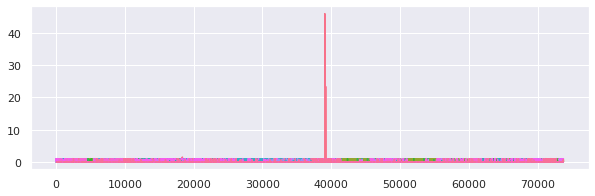

In [24]:
import seaborn as sns
sns.set_theme(style="darkgrid")

plt.figure(figsize=(10,3))
res_plot = SAL_LIST[:,-1:,:]
res_plot = res_plot.reshape(res_plot.shape[0], res_plot.shape[2])
res_plot_mean = np.mean(res_plot, axis=1)
# plt.plot(res_plot_mean) 
# plt.plot(x_test[:,1:2])
# plt.plot(y_test*-1) 


sns.lineplot(data=res_plot_mean, legend=False)
sns.lineplot(data=x_test, legend=False)


In [16]:
plt.figure(figsize=(20,12))
res_plot = np.mean(GUESS[:,-1:,:], axis=2)
res_plot = res_plot.reshape(res_plot.shape[0], res_plot.shape[2])
res_plot_mean = np.mean(res_plot, axis=1)
plt.plot(res_plot)
plt.plot(y_test*-1)


NameError: name 'plt' is not defined

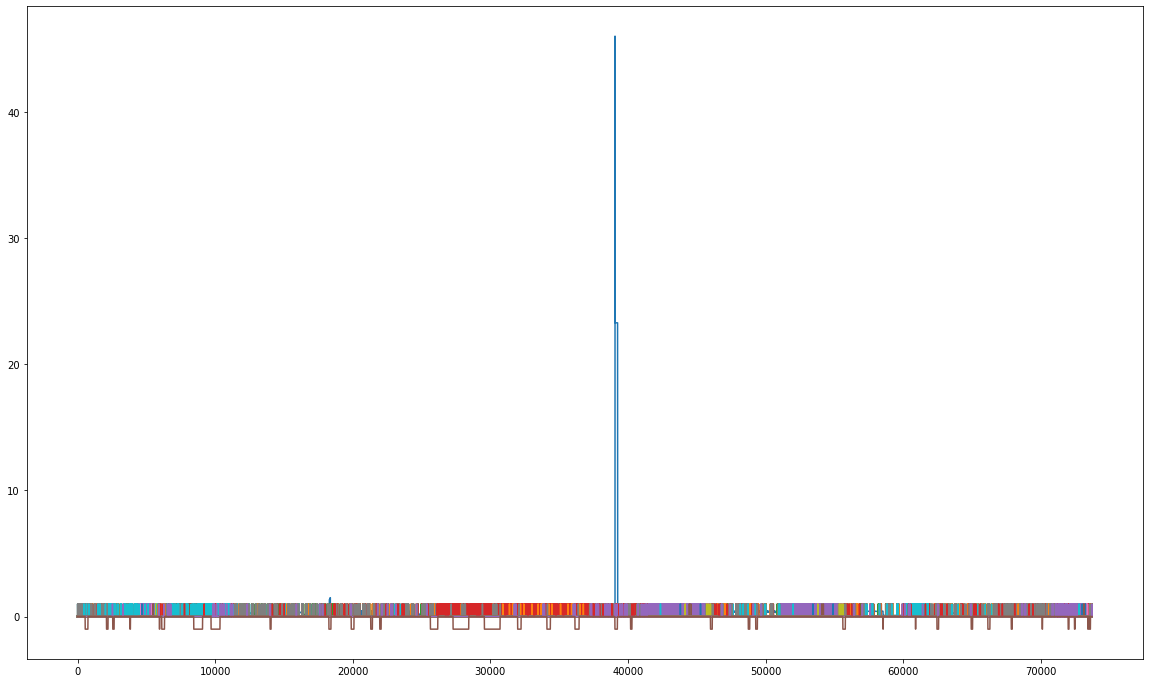

In [15]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(20,12))
total_len = len(x_test)

plt.plot(x_test[:total_len])
plt.plot(y_test[:total_len]*-1)

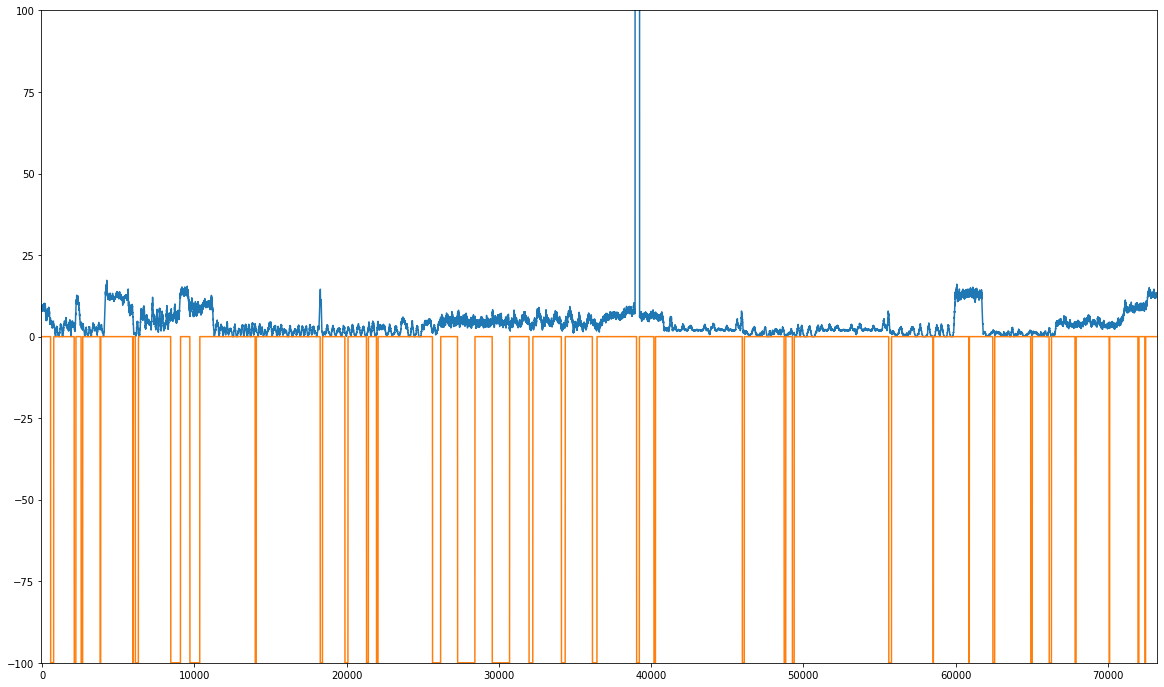

In [51]:
plt.figure(figsize=(20,12))
# plt.plot(DIST)
# plt.plot(DIST_SAL)

plt.plot(np.array(FD2wSAL))
# plt.plot(FIN_DIST2)
# plt.plot(np.array(FIN_DIST1) - np.array(FIN_DIST2))
plt.axis([-50, len(FIN_DIST1)+50, -100, 100])
plt.plot(y_test*-100)


In [34]:
from spot import SPOT, dSPOT
def adjust_predicts(score, label, threshold, pred=None, calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
            score (np.ndarray): The anomaly score
            label (np.ndarray): The ground-truth label
            threshold (float): The threshold of anomaly score.
                    A point is labeled as "anomaly" if its score is lower than the threshold.
            pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
            calc_latency (bool):
    Returns:
            np.ndarray: predict labels

    Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly)
    """
    if label is None:
        predict = score > threshold
        return predict, None

    if pred is None:
        if len(score) != len(label):
            raise ValueError("score and label must have the same length")
        predict = score > threshold
    else:
        predict = pred

    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    latency = 0

    for i in range(len(predict)):
        if any(actual[max(i, 0) : i + 1]) and predict[i] and not anomaly_state:
            anomaly_state = True
            anomaly_count += 1
            for j in range(i, 0, -1):
                if not actual[j]:
                    break
                else:
                    if not predict[j]:
                        predict[j] = True
                        latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
            predict (np.ndarray): the predict label
            actual (np.ndarray): np.ndarray
    Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly)
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN

def pot_eval(init_score, score, label, q=1e-3, level=0.99, dynamic=False):
    """
    Run POT method on given score.
    :param init_score (np.ndarray): The data to get init threshold.
                    For `OmniAnomaly`, it should be the anomaly score of train set.
    :param: score (np.ndarray): The data to run POT method.
                    For `OmniAnomaly`, it should be the anomaly score of test set.
    :param label (np.ndarray): boolean list of true anomalies in score
    :param q (float): Detection level (risk)
    :param level (float): Probability associated with the initial threshold t
    :return dict: pot result dict
    Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly)
    """

    print(f"Running POT with q={q}, level={level}..")
    s = SPOT(q)  # SPOT object
    s.fit(init_score, score)
    s.initialize(level=level, min_extrema=False)  # Calibration step
    ret = s.run(dynamic=dynamic, with_alarm=False)

    print(len(ret["alarms"]))
    print(len(ret["thresholds"]))

    pot_th = np.mean(ret["thresholds"])
    pred, p_latency = adjust_predicts(score, label, pot_th, calc_latency=True)

    plt.figure(figsize=(20,12))
    plt.plot(score)
    plt.plot(label*-50)
    plt.plot(pred*-50, alpha=0.5)
    if dynamic:
        plt.plot(ret["thresholds"])
    else:
        plt.axhline(y=pot_th, color='r', linestyle='-')
    plt.axis([-50, len(score)+50, -100, 100])
    plt.show()


    if label is not None:
        p_t = calc_point2point(pred, label)
        return {
            "f1": p_t[0],
            "precision": p_t[1],
            "recall": p_t[2],
            "TP": p_t[3],
            "TN": p_t[4],
            "FP": p_t[5],
            "FN": p_t[6],
            "threshold": pot_th,
            "latency": p_latency,
        }
    else:
        return {
            "threshold": pot_th,
        }



In [18]:
window_size = 100
batch_size = 256

train_dataset = ReconDataset(x_train[:-100], window_size, 1)
test_dataset = ReconDataset(x_test[:-100], window_size, 1)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, batch_size, val_split=0.0, shuffle=False, test_dataset=test_dataset)
print(len(y_test))
print(len(FIN_DIST))

train_size: 58117
test_size: 73529
73729
73629


Running POT with q=0.01, level=0.99..
Initial threshold : 7.002267
Number of peaks : 404
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 0.41541195
	L = 49.09222057851299
Extreme quantile (probability = 0.01): 7.001783888468453


100%|██████████| 73215/73215 [00:00<00:00, 1779259.57it/s]

0
73215


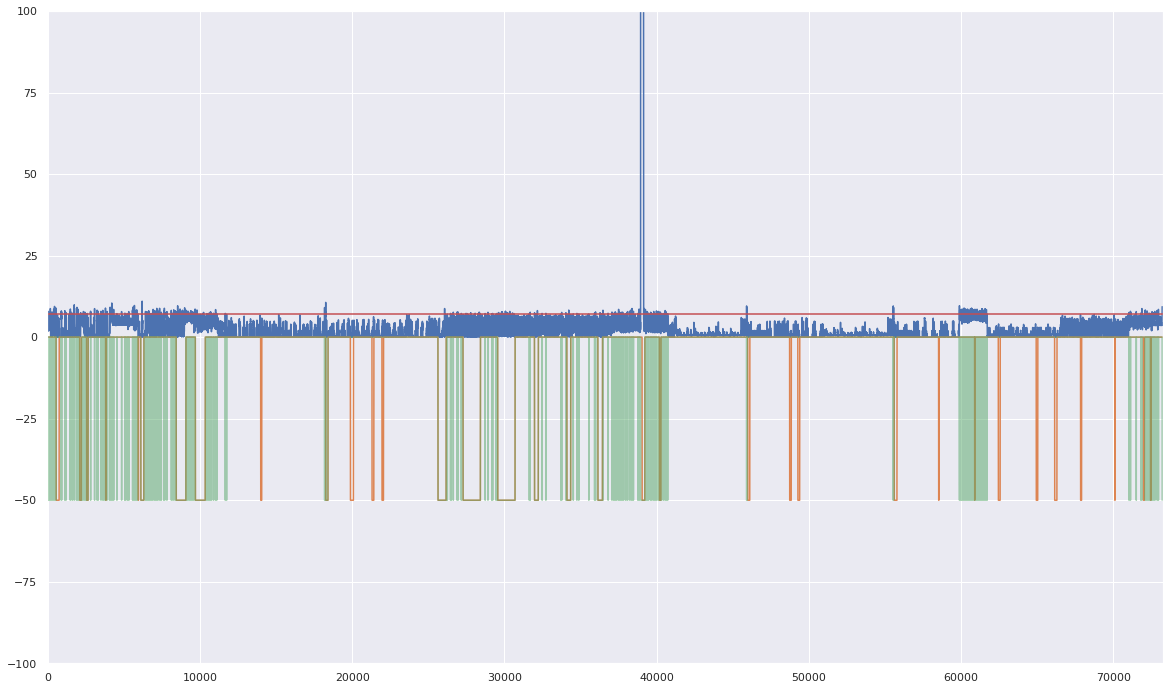

{'f1': 0.7717254109703255,
 'precision': 0.7903314149680479,
 'recall': 0.7539848435406522,
 'TP': 5771,
 'TN': 64030,
 'FP': 1531,
 'FN': 1883,
 'threshold': 7.001783888468453,
 'latency': 77.13281911453923}

In [43]:
latency = 1
pot_th = pot_eval(DIST_train[:-latency], DIST[:-latency], label=y_test[latency:-(len(y_test)-len(DIST))], q=0.01, level=0.99, dynamic=False)
pot_th

Running POT with q=0.01, level=0.9..
Initial threshold : 21.370809078216553
Number of peaks : 4044
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 4.520541374748951
	L = 10144.906836819055
Extreme quantile (probability = 0.01): 31.77895784031177


100%|██████████| 73215/73215 [00:00<00:00, 2147349.20it/s]

0
73215


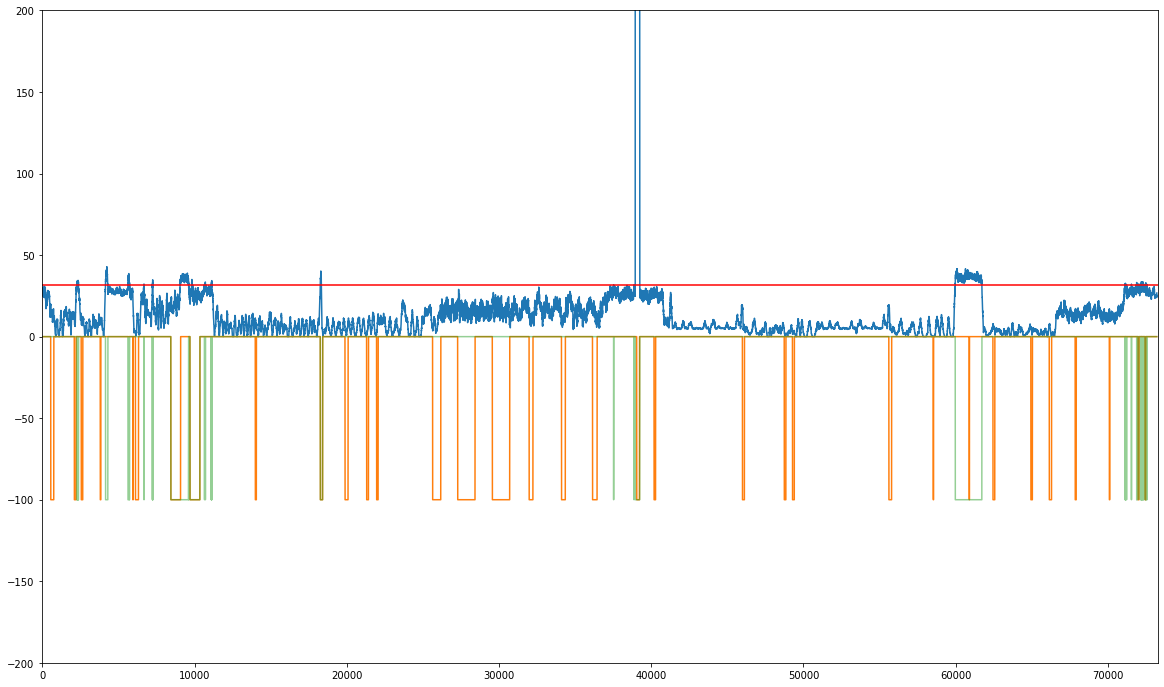

{'f1': 0.2770430412426133,
 'precision': 0.3770528675431882,
 'recall': 0.21897047266923117,
 'TP': 1676,
 'TN': 62792,
 'FP': 2769,
 'FN': 5978,
 'threshold': 31.778957840311765,
 'latency': 124.83125281245313}

In [53]:
latency = 1
pot_th = pot_eval(FIN_DIST2_train[:-latency], FIN_DIST2[:-latency], label=y_test[latency:-(len(y_test)-len(FIN_DIST2))], q=0.01, level=0.9, dynamic=False)
pot_th

Running POT with q=0.001, level=0.2..
Initial threshold : 0.009188617607710059
Number of peaks : 32357
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.32455782563964997
	σ = 0.3224953968802675
	L = 14762.047789570384
Extreme quantile (probability = 0.001): 0.889329434106069


100%|██████████| 73215/73215 [00:00<00:00, 2053990.56it/s]

0
73215


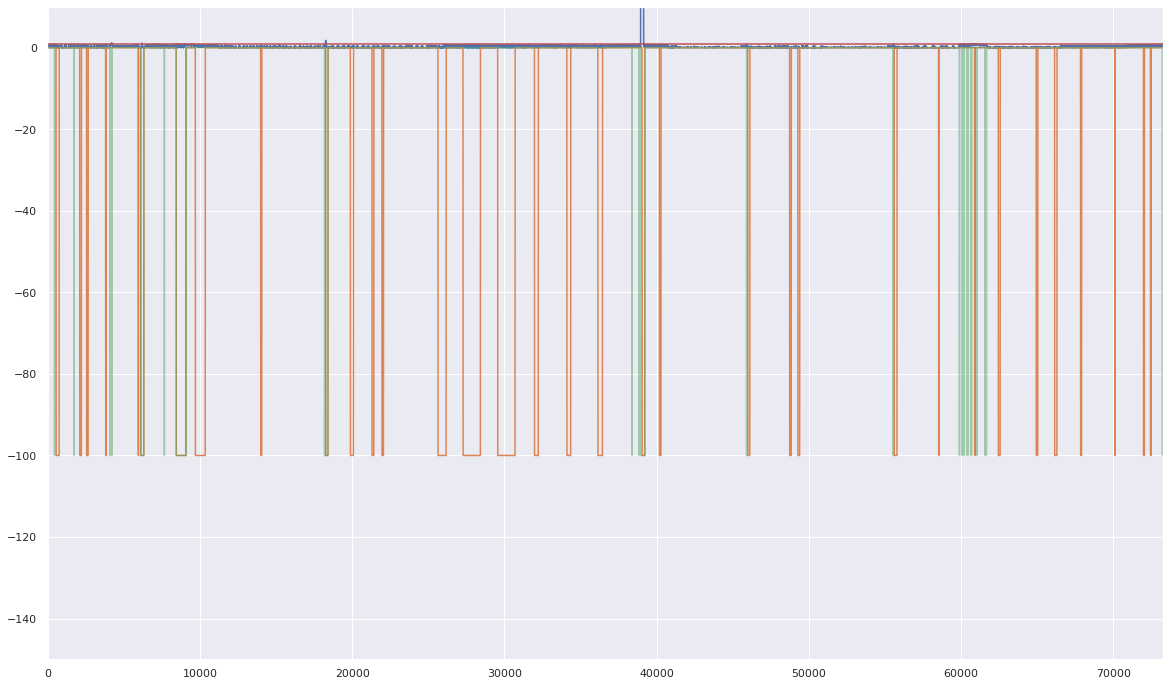

{'f1': 0.26074148015100446,
 'precision': 0.8689859299112811,
 'recall': 0.15338385138047578,
 'TP': 1174,
 'TN': 65384,
 'FP': 177,
 'FN': 6480,
 'threshold': 0.8893294341060687,
 'latency': 46.24884377890553}

In [31]:
latency = 1   
pot_th = pot_eval(FD1wSAL_train[:-latency], FD1wSAL[:-latency], label=y_test[latency:-(len(y_test)-len(FD1wSAL))], q=1e-3, level=0.2, dynamic=False)
pot_th

Running POT with q=0.1, level=0.1..
Initial threshold : 0.5665296206027968
Number of peaks : 36402
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 2.890202447411614
	L = 75036.40909779376
Extreme quantile (probability = 0.1): 6.916929652589934


100%|██████████| 73215/73215 [00:00<00:00, 571462.01it/s]

0
73215


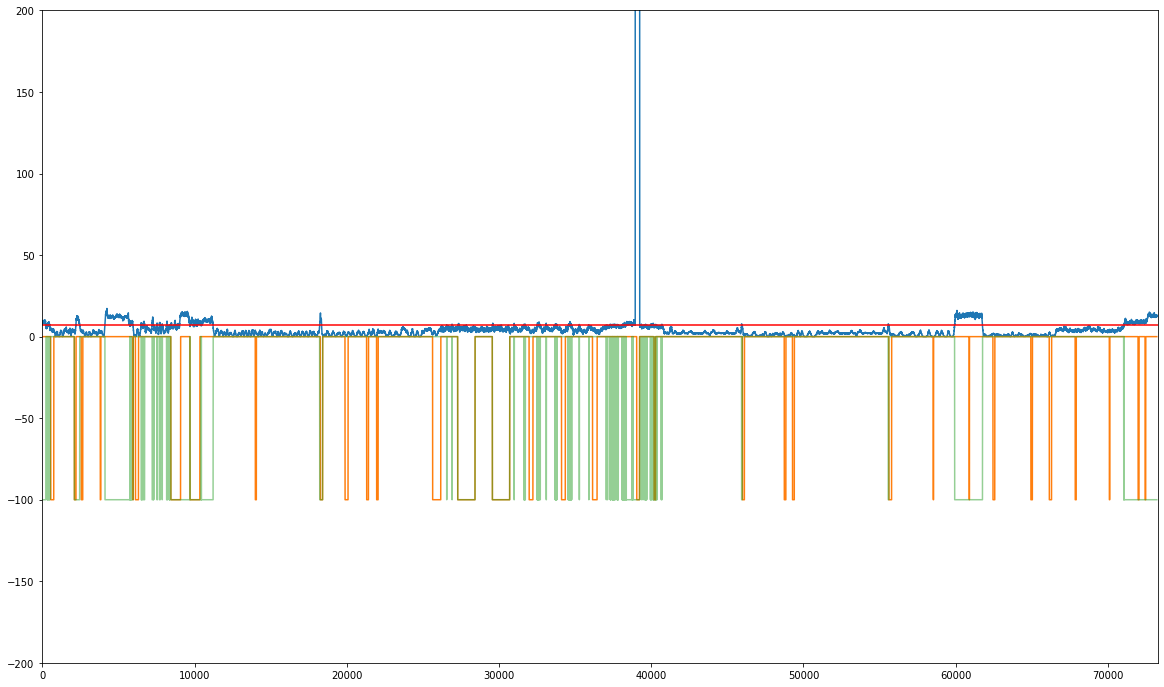

{'f1': 0.3938814813606541,
 'precision': 0.3051090698155073,
 'recall': 0.5555265213541593,
 'TP': 4252,
 'TN': 55877,
 'FP': 9684,
 'FN': 3402,
 'threshold': 6.91692965258993,
 'latency': 16.166531945567122}

In [58]:
latency = 1   
pot_th = pot_eval(FD2wSAL_train[:-latency], FD2wSAL[:-latency], label=y_test[latency:-(len(y_test)-len(FD2wSAL))], q=0.1, level=0.1, dynamic=False)
pot_th

Running POT with q=0.01, level=0.99..
Initial threshold : 0.737727048279222
Number of peaks : 404
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.16156915529690286
	σ = 0.05953917992571149
	L = 801.0067003243196
Extreme quantile (probability = 0.01): 0.7376563438677056


100%|██████████| 73216/73216 [00:00<00:00, 1917875.10it/s]

0
73216


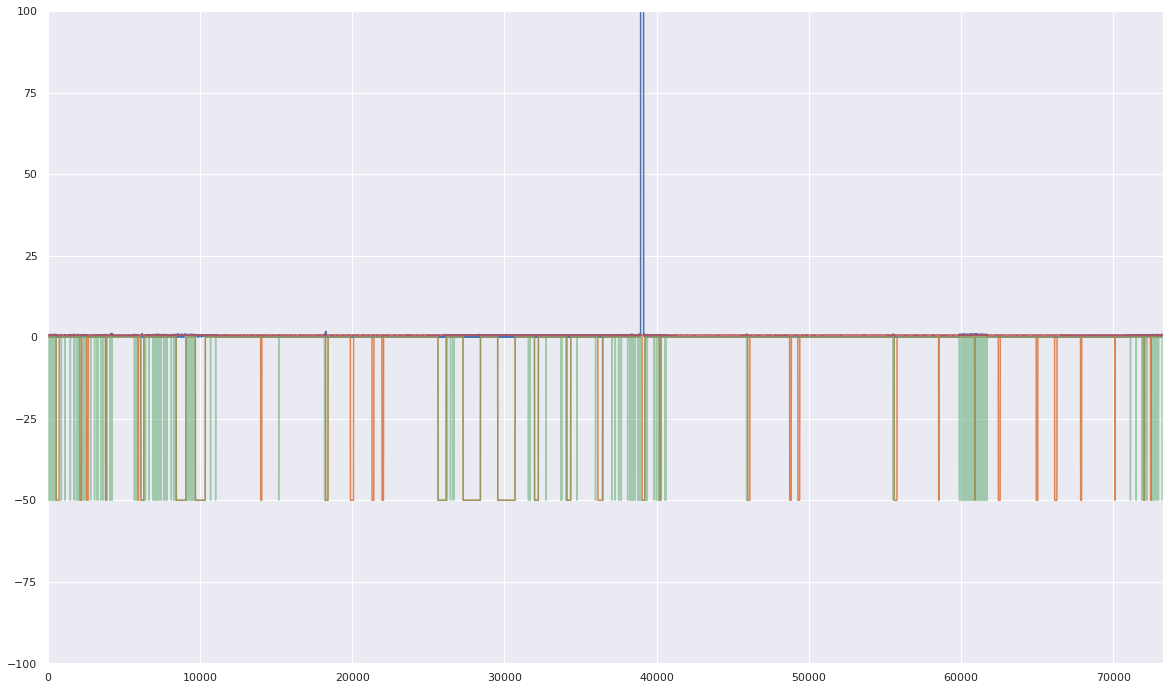

{'f1': 0.7490512404025241,
 'precision': 0.8234925593993853,
 'recall': 0.686961065211705,
 'TP': 5258,
 'TN': 64435,
 'FP': 1127,
 'FN': 2396,
 'threshold': 0.7376563438677054,
 'latency': 96.91585903450805}

In [50]:
pot_th = pot_eval(FD1wSAL_train, FD1wSAL, label=y_test[:-(len(y_test)-len(FD1wSAL))], q=0.01, level=0.99, dynamic=False)
pot_th


Running POT with q=0.01, level=0.99..
Initial threshold : 0.737727048279222
Number of peaks : 404
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.16156915529690286
	σ = 0.05953917992571149
	L = 801.0067003243196
Extreme quantile (probability = 0.01): 0.7376578161585676


100%|██████████| 73215/73215 [00:00<00:00, 2100451.21it/s]

0
73215


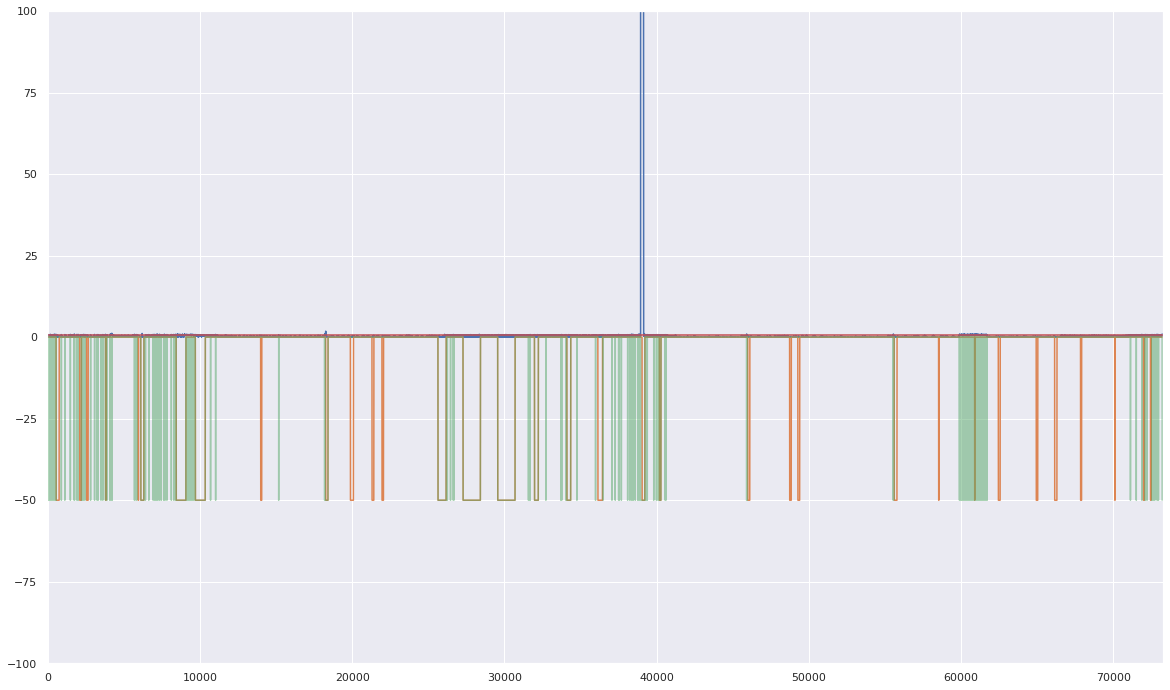

{'f1': 0.7491579665099355, 'precision': 0.8237505862075034, 'recall': 0.686961065211705, 'TP': 5258, 'TN': 64436, 'FP': 1125, 'FN': 2396, 'threshold': 0.7376578161585676, 'latency': 97.7491854234548}
Running POT with q=0.01, level=0.99..
Initial threshold : 0.737544077774448
Number of peaks : 403
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.1628271809157542
	σ = 0.05982162705617604
	L = 797.6237287697745
Extreme quantile (probability = 0.01): 0.7374684130575138


100%|██████████| 73119/73119 [00:00<00:00, 2115713.94it/s]

0
73119


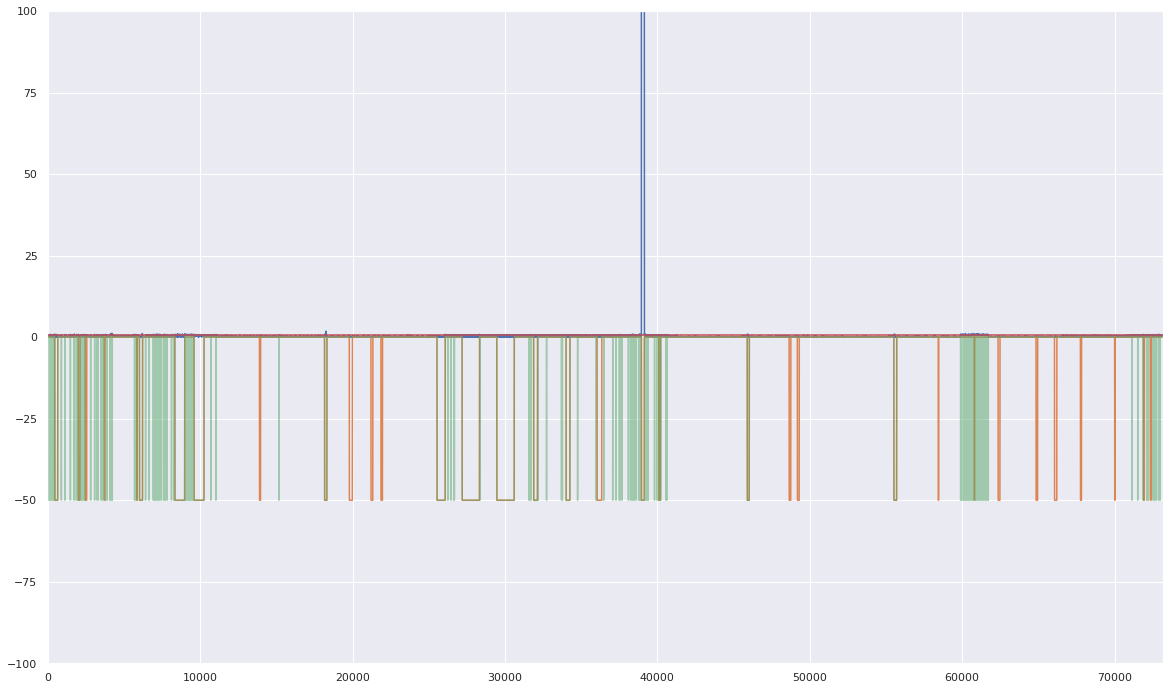

{'f1': 0.810790973892006, 'precision': 0.8546402188292455, 'recall': 0.7712307280229543, 'TP': 5903, 'TN': 64461, 'FP': 1004, 'FN': 1751, 'threshold': 0.7374684130575134, 'latency': 99.05824083387745}


In [52]:
latency = 1
pot_th = pot_eval(FD1wSAL_train[:-latency], FD1wSAL[:-latency], label=y_test[latency:-(len(y_test)-len(FD1wSAL))], q=0.01, level=0.99, dynamic=False)
print(pot_th)
latency = int(pot_th['latency'])
pot_th = pot_eval(FD1wSAL_train[:-latency], FD1wSAL[:-latency], label=y_test[latency:-(len(y_test)-len(FD1wSAL))], q=0.01, level=0.99, dynamic=False)
print(pot_th)

Running POT with q=0.01, level=0.99..
Initial threshold : 3.8317692279815674
Number of peaks : 578
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 0.4823286904595715
	L = 156.56316811655176
Extreme quantile (probability = 0.01): 3.831310482921258


100%|██████████| 73215/73215 [00:00<00:00, 1628075.47it/s]

0
73215


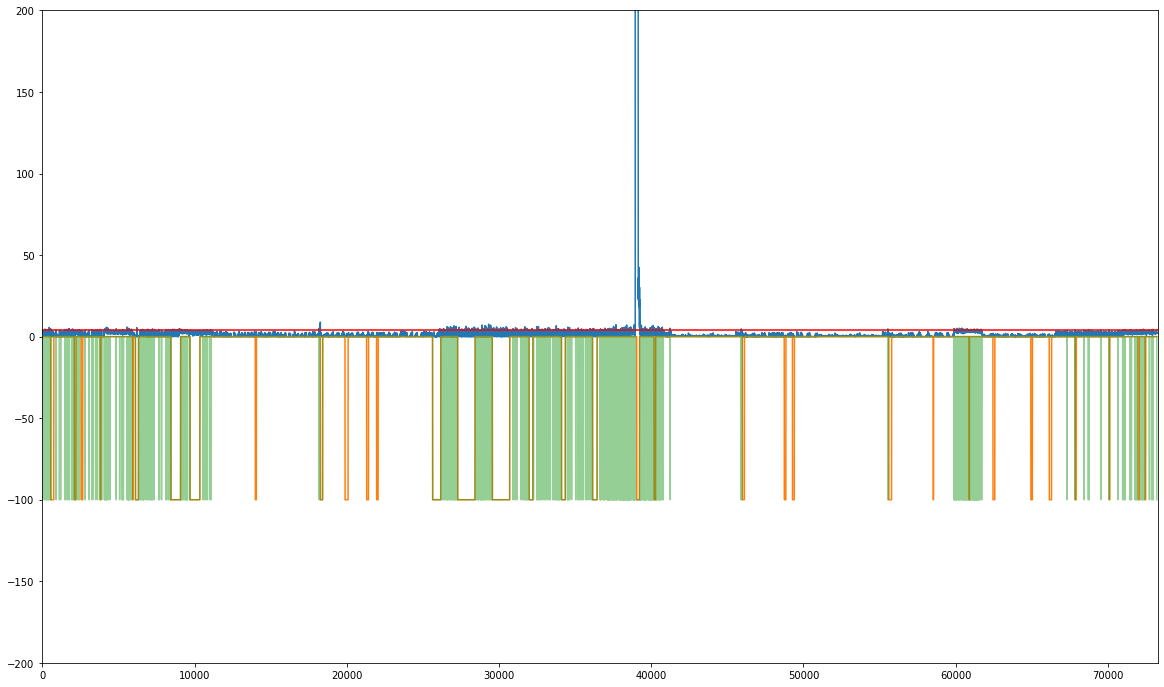

{'f1': 0.7525832668278384,
 'precision': 0.7647693542422858,
 'recall': 0.7407891288988906,
 'TP': 5670,
 'TN': 63817,
 'FP': 1744,
 'FN': 1984,
 'threshold': 3.8313104829212596,
 'latency': 64.92810765637388}

In [80]:
latency = 1
pot_th = pot_eval(FIN_DIST1_train[:-latency], FIN_DIST1[:-latency], label=y_test[latency:-(len(y_test)-len(FIN_DIST1))], q=0.01, level=0.99, dynamic=False)
pot_th

In [26]:
from scipy import signal
b, a = signal.butter(1, 0.1, btype='lowpass')
ANOMALY_SCORE_smooth = signal.filtfilt(b,a,FIN_DIST1)
ANOMALY_SCORE_smooth_train = signal.filtfilt(b,a,FIN_DIST1_train)

Running POT with q=0.01, level=0.99..
Initial threshold : 33.6326588213243
Number of peaks : 578
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 1.1941968730487602
	L = 680.579906500342
Extreme quantile (probability = 0.01): 33.63152301512536


100%|██████████| 73215/73215 [00:00<00:00, 2164726.72it/s]

0
73215


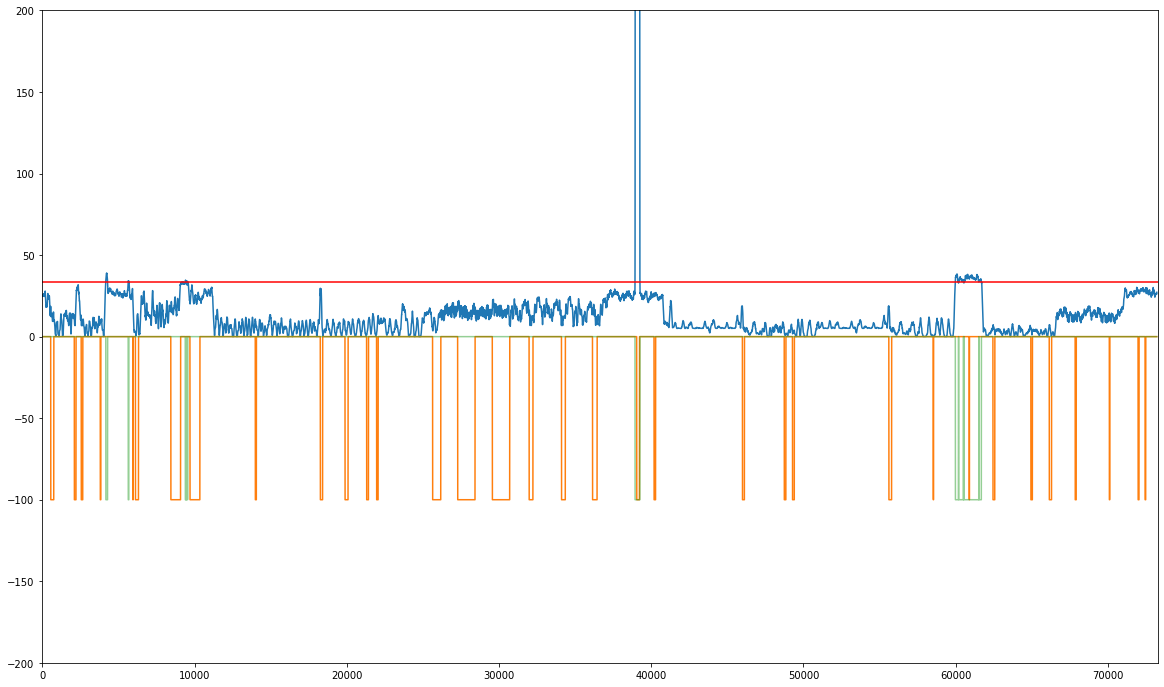

{'f1': 0.03894966295865868,
 'precision': 0.08711433717280245,
 'recall': 0.025084922883348678,
 'TP': 192,
 'TN': 63549,
 'FP': 2012,
 'FN': 7462,
 'threshold': 33.63152301512536,
 'latency': 0.0}

In [34]:
latency = 1
pot_th = pot_eval(ANOMALY_SCORE_smooth_train[:-latency], ANOMALY_SCORE_smooth[:-latency], label=y_test[latency:-(len(y_test)-len(ANOMALY_SCORE_smooth))], q=0.01, level=0.99, dynamic=False)
pot_th

In [59]:
import more_itertools as mit

def epsilon_eval(train_scores, test_scores, test_labels, reg_level=1):
    best_epsilon = find_epsilon(train_scores, reg_level)
    pred, p_latency = adjust_predicts(test_scores, test_labels, best_epsilon, calc_latency=True)
    if test_labels is not None:
        p_t = calc_point2point(pred, test_labels)
        return {
            "f1": p_t[0],
            "precision": p_t[1],
            "recall": p_t[2],
            "TP": p_t[3],
            "TN": p_t[4],
            "FP": p_t[5],
            "FN": p_t[6],
            "threshold": best_epsilon,
            "latency": p_latency,
            "reg_level": reg_level,
        }
    else:
        return {"threshold": best_epsilon, "reg_level": reg_level}


def find_epsilon(errors, reg_level=1):
    """
    Threshold method proposed by Hundman et. al. (https://arxiv.org/abs/1802.04431)
    Code from TelemAnom (https://github.com/khundman/telemanom)
    """
    e_s = errors
    best_epsilon = None
    max_score = -10000000
    mean_e_s = np.mean(e_s)
    sd_e_s = np.std(e_s)

    for z in np.arange(2.5, 12, 0.5):
        epsilon = mean_e_s + sd_e_s * z
        pruned_e_s = e_s[e_s < epsilon]

        i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)
        buffer = np.arange(1, 50)
        i_anom = np.sort(
            np.concatenate(
                (
                    i_anom,
                    np.array([i + buffer for i in i_anom]).flatten(),
                    np.array([i - buffer for i in i_anom]).flatten(),
                )
            )
        )
        i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]
        i_anom = np.sort(np.unique(i_anom))

        if len(i_anom) > 0:
            groups = [list(group) for group in mit.consecutive_groups(i_anom)]
            # E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

            mean_perc_decrease = (mean_e_s - np.mean(pruned_e_s)) / mean_e_s
            sd_perc_decrease = (sd_e_s - np.std(pruned_e_s)) / sd_e_s
            if reg_level == 0:
                denom = 1
            elif reg_level == 1:
                denom = len(i_anom)
            elif reg_level == 2:
                denom = len(i_anom) ** 2

            score = (mean_perc_decrease + sd_perc_decrease) / denom

            if score >= max_score and len(i_anom) < (len(e_s) * 0.5):
                max_score = score
                best_epsilon = epsilon

    if best_epsilon is None:
        best_epsilon = np.max(e_s)
    return best_epsilon


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, verbose=True):
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Method from OmniAnomaly (https://github.com/NetManAIOps/OmniAnomaly)
    """

    print(f"Finding best f1-score by searching for threshold..")
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1.0, -1.0, -1.0)
    m_t = 0.0
    m_l = 0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target, latency = calc_seq(score, label, threshold)
        if target[0] > m[0]:
            m_t = threshold
            m = target
            m_l = latency
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)

    return {
        "f1": m[0],
        "precision": m[1],
        "recall": m[2],
        "TP": m[3],
        "TN": m[4],
        "FP": m[5],
        "FN": m[6],
        "threshold": m_t,
        "latency": m_l,
    }


def calc_seq(score, label, threshold):
    predict, latency = adjust_predicts(score, label, threshold, calc_latency=True)
    return calc_point2point(predict, label), latency

In [ ]:
best_valid_metrics = {}
t, th = bf_search(test_score, y_test[-len(test_score):],
                                      start=config.bf_search_min,
                                      end=config.bf_search_max,
                                      step_num=int(abs(config.bf_search_max - config.bf_search_min) /
                                                   config.bf_search_step_size),
                                      display_freq=50)
# get pot results
pot_result = pot_eval(train_score, test_score, y_test[-len(test_score):], level=config.level)

# output the results
best_valid_metrics.update({
    'best-f1': t[0],
    'precision': t[1],
    'recall': t[2],
    'TP': t[3],
    'TN': t[4],
    'FP': t[5],
    'FN': t[6],
    'latency': t[-1],
    'threshold': th
})
best_valid_metrics.update(pot_result)

In [60]:
dataset = 'MSL'
group = '1'
reg_level_dict = {"SMAP": 0, "MSL": 0, "SMD-1": 1, "SMD-2": 1, "SMD-3": 1}
key = "SMD-" + group if dataset == "SMD" else dataset
reg_level = reg_level_dict[key]

FD1wSAL_train = np.array(FD1wSAL_train)
FD1wSAL = np.array(FD1wSAL)
e_eval = epsilon_eval(FD1wSAL_train, FD1wSAL, y_test[:-(len(y_test)-len(FD1wSAL))], reg_level=reg_level)
print("e_eval:", e_eval)

bf_eval = bf_search(FD1wSAL, y_test[:-(len(y_test)-len(FD1wSAL))], start=0, end=200, step_num=100, verbose=False)
print("bf_eval;", bf_eval)


e_eval: {'f1': 0.6030345550057847, 'precision': 0.49670162339588836, 'recall': 0.7673112088224312, 'TP': 5873, 'TN': 59611, 'FP': 5951, 'FN': 1781, 'threshold': 1.1618808547432227, 'latency': 42.999747060311414, 'reg_level': 0}
Finding best f1-score by searching for threshold..
bf_eval; {'f1': 0.6565492040918467, 'precision': 0.9156147711182451, 'recall': 0.5117585569483165, 'TP': 3917, 'TN': 65201, 'FP': 361, 'FN': 3737, 'threshold': 2.0, 'latency': 326.28105312781247}


e_eval: {'f1': 0.742653302451278, 'precision': 0.6970773630979056, 'recall': 0.7946171925860763, 'TP': 6082, 'TN': 62919, 'FP': 2643, 'FN': 1572, 'threshold': 3.591116697218308, 'latency': 43.44420308776063, 'reg_level': 0}
Finding best f1-score by searching for threshold..
bf_eval; {'f1': 0.7191525181934691, 'precision': 0.7961611662497444, 'recall': 0.6557355622475365, 'TP': 5019, 'TN': 64277, 'FP': 1285, 'FN': 2635, 'threshold': 4.0, 'latency': 68.38408935315883}
Running POT with q=0.01, level=0.9..
Initial threshold : 2.6148886680603027
Number of peaks : 5785
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 0.5741386235945165
	L = 2574.9937037693303
Extreme quantile (probability = 0.01): 3.9368321594957116


100%|██████████| 73216/73216 [06:19<00:00, 193.10it/s] 


0
73216


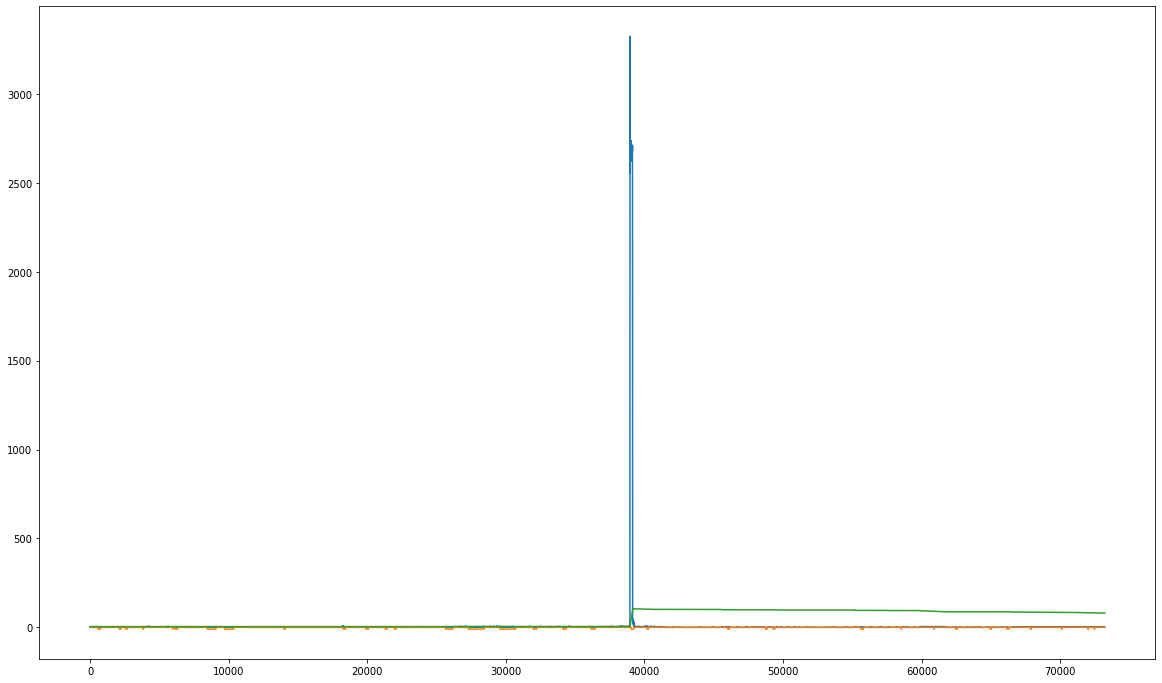

p_eval: {'f1': 0.04564300247853736, 'precision': 0.6534295792985712, 'recall': 0.023647765843156827, 'TP': 181, 'TN': 65466, 'FP': 96, 'FN': 7473, 'threshold': 45.89773801041539, 'latency': 0.0}


In [27]:
dataset = 'MSL'
group = '1'
reg_level_dict = {"SMAP": 0, "MSL": 0, "SMD-1": 1, "SMD-2": 1, "SMD-3": 1}
key = "SMD-" + group if dataset == "SMD" else dataset
reg_level = reg_level_dict[key]

FIN_DIST1_train = np.array(FIN_DIST1_train)
FIN_DIST1 = np.array(FIN_DIST1)
e_eval = epsilon_eval(FIN_DIST1_train, FIN_DIST1, y_test[:-(len(y_test)-len(FIN_DIST1))], reg_level=reg_level)
print("e_eval:", e_eval)

bf_eval = bf_search(FIN_DIST1, y_test[:-(len(y_test)-len(FIN_DIST1))], start=0, end=200, step_num=100, verbose=False)
print("bf_eval;", bf_eval)

p_eval = pot_eval(FIN_DIST1_train, FIN_DIST1, y_test[:-(len(y_test)-len(FIN_DIST1))],
                    q=0.01, level=0.9, dynamic=True)
print("p_eval:", p_eval)  

In [1]:
pot_th = pot_eval(FIN_DIST_train, FIN_DIST, label=y_test[:-(len(y_test)-len(FIN_DIST))], q=0.05, level=0.99, dynamic=True)
pot_th

NameError: name 'pot_eval' is not defined

Running POT with q=0.01, level=0.99..
Initial threshold : 132.33325
Number of peaks : 582
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 4.6696057
	L = 1478.905441884447
Extreme quantile (probability = 0.01): 132.33188817810918


100%|██████████| 73629/73629 [00:00<00:00, 2149017.49it/s]

0
73629


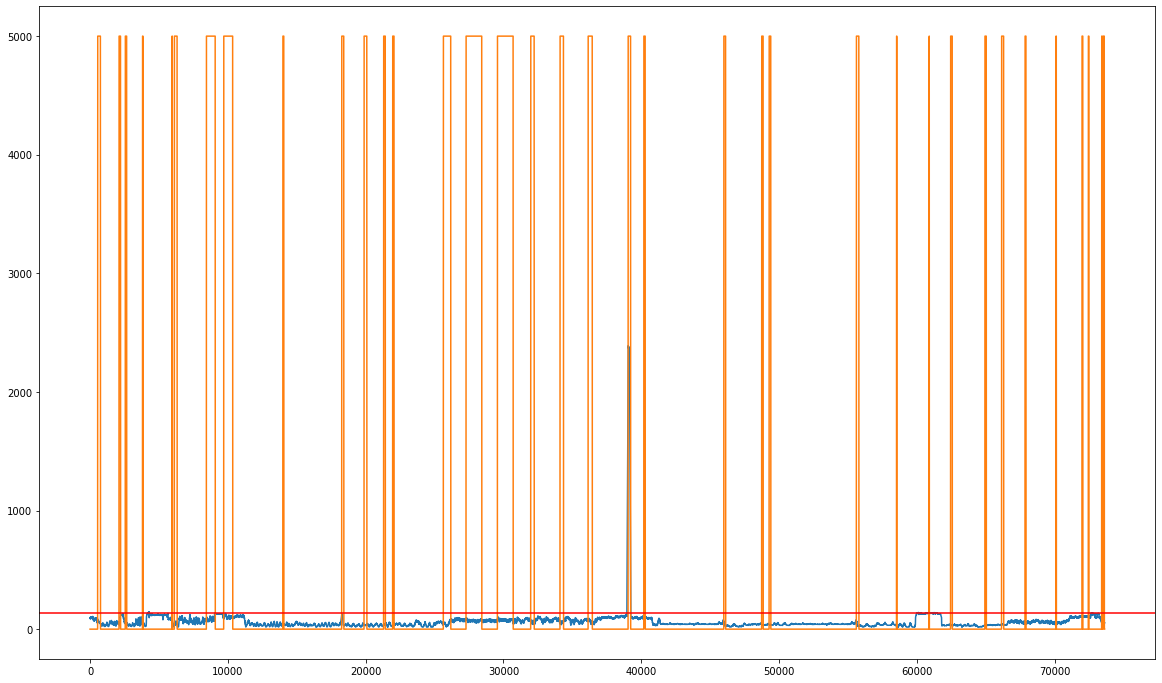

{'f1': 0.28107621036246055,
 'precision': 0.5425414344657774,
 'recall': 0.18967293305476057,
 'TP': 1473,
 'TN': 64621,
 'FP': 1242,
 'FN': 6293,
 'threshold': 132.33188817810924,
 'latency': 243.99186693776872}

In [30]:
pot_th = pot_eval(DIST_SAL_train, DIST_SAL, label=y_test[:len(y_test)-100], q=1e-2, level=0.99, dynamic=False)
pot_th

### Concat input and train



In [57]:
window_size = 100
batch_size = 128

temp_FT = residual_recons_FT[:,-1:,:]
res_train = temp_FT.reshape(temp_FT.shape[0], temp_FT.shape[2])
temp = residual_recons[:,-1:,:]
res_test = temp.reshape(temp.shape[0], temp.shape[2])


res_train_dataset = ReconDataset(res_train, window_size, 1)
res_test_dataset = ReconDataset(res_test, window_size, 1)
res_train_loader, res_val_loader, res_test_loader = create_data_loaders(res_train_dataset, batch_size, val_split=0.0, shuffle=False, test_dataset=res_test_dataset)



train_size: 134983
test_size: 427417


In [58]:
def train_concat(dataloader, res_dataloader, model, batch_size, n_epochs):
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for i, ((x,y), (res_x, res_y)) in enumerate(zip(dataloader, res_dataloader)):  
            optimizer.zero_grad()
            x = x.cuda()
            res_x = res_x.cuda()
            x_res = torch.cat([x, res_x], dim=2)
            enc_output, guess = model(x_res)  # AE
            y = y.cuda()
            # res_y = res_y.cuda()
            # y_res = torch.cat([y, res_y], dim=2)

            loss = loss_fn(y, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}]')
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history



In [59]:
MODEL = RecurrentAutoencoder(seq_len=window_size, n_features=x_train.shape[1]*2, out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2))
MODEL.cuda()

RecurrentAutoencoder(
  (encoder): RecurEncoder(
    (rnn1): LSTM(50, 24, batch_first=True)
    (rnn2): LSTM(24, 12, batch_first=True)
  )
  (decoder): RecurDecoder(
    (rnn1): LSTM(12, 12, batch_first=True)
    (rnn2): LSTM(12, 24, batch_first=True)
    (output_layer): Linear(in_features=24, out_features=25, bias=True)
    (timedist): TimeDistributed(
      (module): Linear(in_features=24, out_features=25, bias=True)
    )
  )
)

In [62]:
BEST_MODEL, LOSS_HISTORY = train_concat(train_loader, res_train_loader, MODEL, batch_size, 1000)
with open("result/model_VANLSTMAE_saliency_res_SMAP.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

Training loss EPOCH: [1|1000], training loss: [4.732401983987074]
Training loss EPOCH: [2|1000], training loss: [4.6379594555764925]
Training loss EPOCH: [3|1000], training loss: [4.497341679467354]
Training loss EPOCH: [4|1000], training loss: [4.349543998760055]
Training loss EPOCH: [5|1000], training loss: [4.349176435527625]
Training loss EPOCH: [6|1000], training loss: [4.347822166411788]
Training loss EPOCH: [7|1000], training loss: [4.378227562236134]
Training loss EPOCH: [8|1000], training loss: [4.33640863441542]
Training loss EPOCH: [9|1000], training loss: [4.311939880484715]
Training loss EPOCH: [10|1000], training loss: [4.3115411050239345]
Training loss EPOCH: [11|1000], training loss: [4.298871330844122]
Training loss EPOCH: [12|1000], training loss: [4.290227390414657]
Training loss EPOCH: [13|1000], training loss: [4.281493877533649]
Training loss EPOCH: [14|1000], training loss: [4.290150342378183]
Training loss EPOCH: [15|1000], training loss: [4.308580595636158]
Tra

In [135]:
with open("result/model_VANLSTMAE_saliency_res_SMD1-2.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

print(SAVED_MODEL['best_epoch'])

MODEL_res = RecurrentAutoencoder(seq_len=window_size, n_features=x_train.shape[1]*2, out_n_features=x_train.shape[1], embedding_dim=int(x_train.shape[1]/2))
MODEL_res.cuda()
MODEL_res.load_state_dict(SAVED_MODEL["state"])
MODEL_res

998


RecurrentAutoencoder(
  (encoder): RecurEncoder(
    (rnn1): LSTM(76, 38, batch_first=True)
    (rnn2): LSTM(38, 19, batch_first=True)
  )
  (decoder): RecurDecoder(
    (rnn1): LSTM(19, 19, batch_first=True)
    (rnn2): LSTM(19, 38, batch_first=True)
    (output_layer): Linear(in_features=38, out_features=76, bias=True)
    (timedist): TimeDistributed(
      (module): Linear(in_features=38, out_features=76, bias=True)
    )
  )
)

In [136]:
def inference_concat(dataloader, res_dataloader, model, batch_size):
    ts, dist, att, guess_res, enc_list = [], [], [], [], []
    mse = torch.nn.MSELoss()
    with torch.no_grad():
        for i, ((x,y),(res_x,res_y)) in enumerate(zip(dataloader, res_dataloader)):
            x = x.cuda()
            res_x = res_x.cuda()
            x_res = torch.cat([x, res_x], dim=2)
            y = y.cuda()
            res_y = res_y.cuda()
            y_res = torch.cat([y, res_y], dim=2)
            enc, guess = model(x_res)
            # ts.append(np.array(batch["ts"]))
            
            for y_s, g in zip(y_res, guess):
                dist.append(torch.sum(torch.abs(y_s - g)).cpu().numpy())  # Normal GRU

            guess_res.append(guess.cpu().numpy())
            enc_list.append(enc.cpu().numpy())
        
            
    return (
        # np.concatenate(ts),
        # np.concatenate(dist),
        dist,
        np.concatenate(guess_res),
        np.concatenate(enc_list)
    )

In [137]:
MODEL.eval()
CHECK_DIST, GUESS_RES, ENC = inference_concat(test_loader, res_test_loader, MODEL_res, batch_size)
CHECK_DIST_FT, GUESS_RES_FT, ENC_FT = inference_concat(train_loader, res_train_loader, MODEL_res, batch_size)

In [138]:
len(y_test)

23694

Running POT with q=0.01, level=0.99..
Initial threshold : 220.43707
Number of peaks : 234
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 17.196493
	L = 899.66108146221
Extreme quantile (probability = 0.01): 220.36813120398338


100%|██████████| 23494/23494 [00:00<00:00, 1161245.59it/s]

0
23494


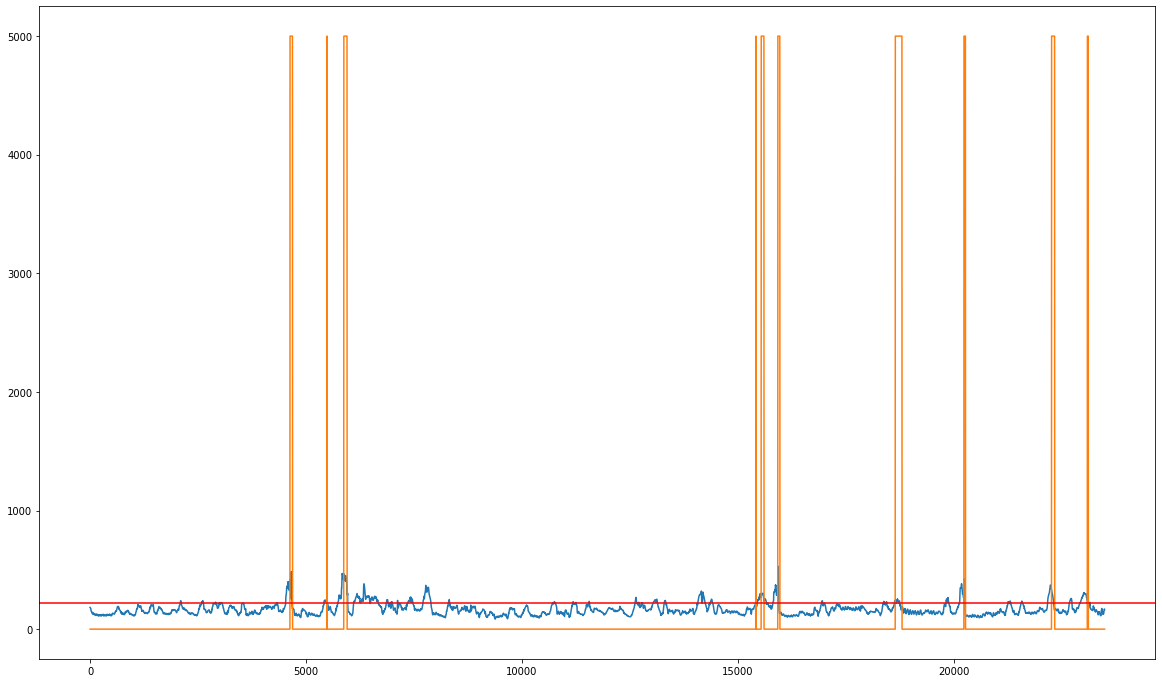

{'f1': 0.27534882638157626,
 'precision': 0.15979839857753217,
 'recall': 0.9944649263013852,
 'TP': 539.0,
 'TN': 20118.0,
 'FP': 2834.0,
 'FN': 3.0,
 'threshold': 220.36813120398344,
 'latency': 0.0}

In [142]:
pot_th = pot_eval(CHECK_DIST_FT, CHECK_DIST, label=y_test[:len(y_test)-200], q=1e-2, level=0.99, dynamic=False)
pot_th

In [53]:
from torch.autograd import Variable
# x = torch.randn(1, 1, 100)
reshape_len = len(ENC)
x = torch.Tensor(np.array(ENC).reshape(ENC.shape[0],ENC.shape[2],ENC.shape[1])) 
k_size = 100
mean_conv = torch.nn.Conv1d(in_channels=19,
                      out_channels=19,
                      kernel_size=k_size)

# Set kernel to calculate mean
kernel_weights = np.ones((k_size, 19))/k_size
mean_conv.weight.data = torch.FloatTensor(kernel_weights).view(1, 19, k_size)
output = mean_conv(Variable(x))

RuntimeError: Given weight of size [1, 19, 100], expected bias to be 1-dimensional with 1 elements, but got bias of size [19] instead

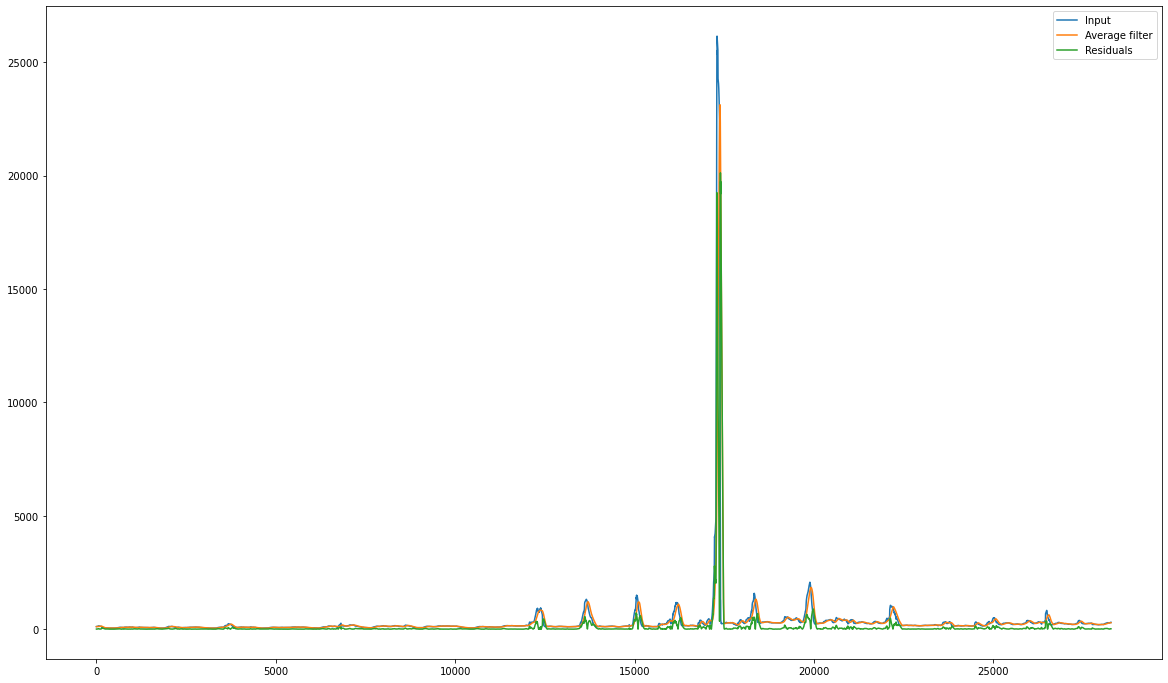

In [99]:
plt.figure(figsize=(20,12))
x_np = x.numpy().reshape(reshape_len)
plt.plot(x_np[k_size-1:], label='Input')
output_np = output.detach().numpy().reshape(reshape_len - k_size + 1)
plt.plot(output_np, label='Average filter')
plt.plot(abs(x_np[k_size-1:] - output_np), label='Residuals')
plt.legend()

In [7]:
# MODEL2 = torch.nn.Transformer(d_model=x_train.shape[1], nhead=int(x_train.shape[1]/2), num_encoder_layers=6)
MODEL2 = torch.nn.TransformerAE(d_model=x_train.shape[1], nhead=int(x_train.shape[1]/2), num_encoder_layers=6)
MODEL2.cuda()

TransformerAE(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=38, out_features=38, bias=True)
        )
        (linear1): Linear(in_features=38, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=38, bias=True)
        (norm1): LayerNorm((38,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((38,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=38, out_features=38, bias=True)
        )
        (linear1): Linear(in_features=38, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(

In [8]:
def train_transformer(dataloader, model, batch_size, n_epochs):
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = range(n_epochs)
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for i, (x,y) in enumerate(dataloader):  
            optimizer.zero_grad()
            x = x.cuda()
            enc_output, guess = model(x,x)  # Transformer
            y = y.cuda()
            loss = loss_fn(y, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
#         epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        
        print(f'Training loss EPOCH: [{e+1}|{len(epochs)}], training loss: [{epoch_loss}]')
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [9]:
BEST_MODEL2, LOSS_HISTORY2 = train_transformer(train_loader, MODEL2, batch_size, 1000)
with open("result/model_transformerAE_saliency.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL2["state"],
            "best_epoch": BEST_MODEL2["epoch"],
            "loss_history": LOSS_HISTORY2,
        },
        f,
    )

Training loss EPOCH: [1|1000], training loss: [79.69933512806892]
Training loss EPOCH: [2|1000], training loss: [32.63320318609476]
Training loss EPOCH: [3|1000], training loss: [8.479595061391592]
Training loss EPOCH: [4|1000], training loss: [2.684080082923174]
Training loss EPOCH: [5|1000], training loss: [1.7842128300108016]
Training loss EPOCH: [6|1000], training loss: [1.7028404148295522]
Training loss EPOCH: [7|1000], training loss: [1.6957667423412204]
Training loss EPOCH: [8|1000], training loss: [1.6935093654319644]
Training loss EPOCH: [9|1000], training loss: [1.692588483914733]
Training loss EPOCH: [10|1000], training loss: [1.6864340733736753]
Training loss EPOCH: [11|1000], training loss: [1.6859813164919615]
Training loss EPOCH: [12|1000], training loss: [1.6856106729246676]
Training loss EPOCH: [13|1000], training loss: [1.6818020781502128]
Training loss EPOCH: [14|1000], training loss: [1.6826780391857028]
Training loss EPOCH: [15|1000], training loss: [1.686342430301

In [11]:
with open("result/model_transformerAE_saliency.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

print(SAVED_MODEL['best_epoch'])

MODEL2 = torch.nn.Transformer(d_model=x_train.shape[1], nhead=int(x_train.shape[1]/2), num_encoder_layers=6)
MODEL2.cuda()
MODEL2.load_state_dict(SAVED_MODEL["state"])



749


<All keys matched successfully>

In [ ]:
MODEL2.eval()
CHECK_DIST, GUESS_RES, ENC = inference(test_loader, MODEL2, batch_size)
CHECK_DIST_FT, GUESS_RES_FT, ENC_FT = inference(train_loader, MODEL2, batch_size)

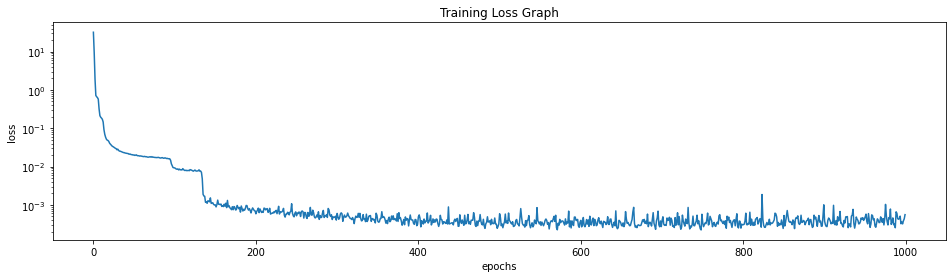

In [12]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [21]:
def inference_transformer(dataloader, model, batch_size):
    # dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att, enc_val_res, guess_res = [], [], [], [], []
    mse = torch.nn.MSELoss()
    with torch.no_grad():
        for i, (x,y) in enumerate(dataloader):
            x = x.cuda()
            y = y.cuda()
            # guess = model(given, given)
            enc_val, guess = model(x,x)
            
            # ts.append(np.array(batch["ts"]))
            for j, (guess, y_s) in enumerate(zip(x,y)):
                dist.append(torch.abs(y_s - guess).cpu().numpy())
            # dist.append(np.asscalar(torch.sum(torch.abs(y - guess)).cpu().numpy()))
            # dist.append(torch.abs(answer - guess).cpu().numpy())  # Normal GRU

            # for i, (ans, gue) in enumerate(zip(answer, guess)):
            #     dist.append(mse(ans, gue).item())  # Transformer / AE structure
            enc_val_res.append(enc_val.cpu().numpy())
            guess_res.append(guess.cpu().numpy())
            # try:
            #     att.append(np.array(batch["attack"]))
            # except:
            #     att.append(np.zeros(batch_size))
        
            
    return (
        # np.concatenate(ts),
        np.concatenate(dist),
        # np.concatenate(att),
        np.concatenate(enc_val_res),
        np.concatenate(guess_res)
    )




In [22]:
MODEL2.eval()

CHECK_TS, CHECK_DIST, CHECK_ATT, ENC_LIST_TRANS, GUESS_RES = inference_transformer(test_loader, MODEL2, batch_size)
CHECK_TS_TRAIN, CHECK_DIST_TRAIN, CHECK_ATT_TRAIN, ENC_LIST_TRANS_TRAIN, GUESS_RES_TRAIN = inference_transformer(test_loader, MODEL2, batch_size)

ValueError: not enough values to unpack (expected 5, got 3)